<a href="https://colab.research.google.com/github/ahmadayoubi404/Deep-Learning/blob/main/8_Human_Emotions_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Downloading**

first i got the kaggle.json from my kaggle account (also available in DL folder in my pc)

In [10]:
!pip install -q kaggle

create directory and copy the json file in it

In [11]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


giving the user persmission to read and write into this kaggle file

In [12]:
!chmod 600 /root/.kaggle/kaggle.json

API from the kaggle dataset in kaggle.com in order to download the dataset

In [13]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip and store

In [15]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# **Dataset Loading**

In [280]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np


In [281]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
class_names = ["angry", "happy", "sad"]

configuration = {
    'batch_size': 32,
    'image_size': 50, #should be 256 due to low computational power i used 50
    "learning_rate": 0.001,
    "nb_epochs": 20,
    "dropout_rate": 0.0,
    "nb_filters": 6,
    "kernel_size": 3,
    "nb_strides": 1,
    "pool_size": 2,
    "nb_dense_1": 128,
    "nb_dense_2": 64,
    "nb_classes": 3,
    "regularization_rate": 0.0,
}

In [282]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    # batch_size=32,
    # image_size=(256, 256),
    batch_size = configuration['batch_size'],
    image_size = (configuration['image_size'], configuration['image_size']),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [283]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = val_directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    #batch_size=32,
    #image_size=(256, 256),
    batch_size = configuration['batch_size'],
    image_size = (configuration['image_size'], configuration['image_size']),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [284]:
for image, label in train_dataset.take(1):
  print(image.shape)
  print(label.numpy())

(32, 50, 50, 3)
[2 0 1 0 2 1 0 1 0 0 1 1 0 2 1 1 1 2 0 2 0 1 1 2 1 0 1 2 2 1 0 2]


# **Dataset Visualtization**

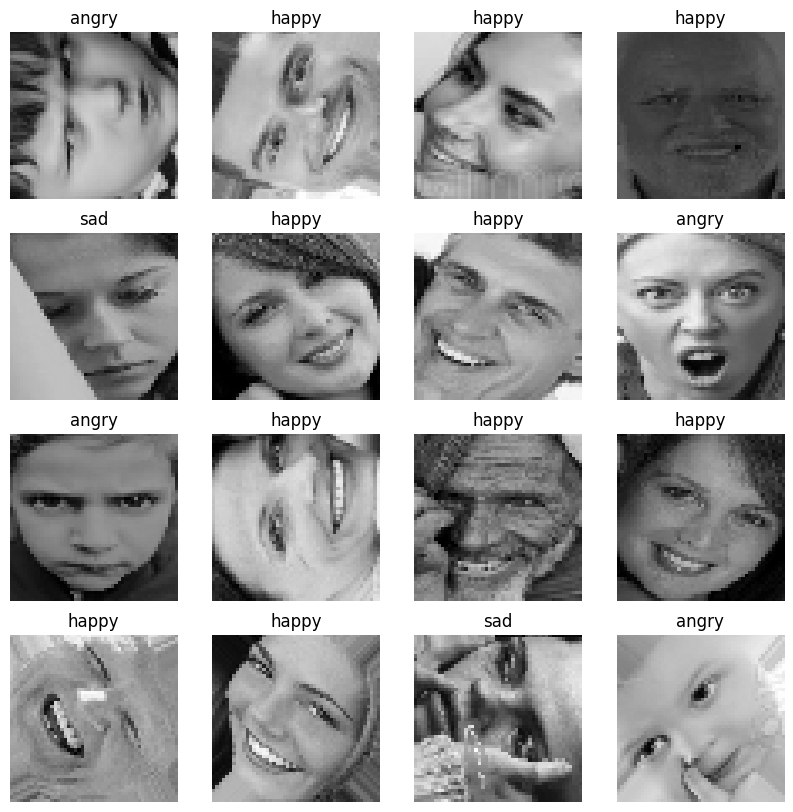

In [285]:
plt.figure(figsize = (10, 10))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    #plt.imshow(images[i]/255) #this also works fine
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

# **Dataset Preparation**

prefetching the training dataset for more efficient usage of our data

the training and validation datasets are already batched when we did batch_size in the Dataset Loading earlier

In [286]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [287]:
val_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [288]:
from tensorflow.keras.layers import Resizing, Rescaling

im_size = 256
resize_rescale_layers = tf.keras.Sequential([
    Resizing(configuration["image_size"], configuration["image_size"]),
    Rescaling(1./255),
])

# **Modeling**

LeNet Model

In [289]:
lenet_model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(None, None, 3)), #resizing after
      resize_rescale_layers,
      tf.keras.layers.Conv2D(filters = configuration["nb_filters"], kernel_size =configuration["kernel_size"], strides = configuration["nb_strides"], padding = 'valid', activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(configuration["regularization_rate"])),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size = configuration["pool_size"], strides = configuration["nb_strides"] * 2),
      tf.keras.layers.Dropout(rate = configuration["dropout_rate"]),

      tf.keras.layers.Conv2D(filters = configuration["nb_filters"] * 2 + 4, kernel_size =configuration["kernel_size"], strides = configuration["nb_strides"], padding = 'valid', activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(configuration["regularization_rate"])),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size = configuration["pool_size"], strides = configuration["nb_strides"] * 2),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(configuration["nb_dense_1"], activation='relu', kernel_regularizer = tf.keras.regularizers.L2(configuration["regularization_rate"])),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate = configuration["dropout_rate"]),
      tf.keras.layers.Dense(configuration["nb_dense_2"], activation='relu', kernel_regularizer = tf.keras.regularizers.L2(configuration["regularization_rate"])),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(configuration["nb_classes"], activation='softmax')
  ])
lenet_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)           │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 48, 48, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 24, 24, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 24, 24, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 22, 22, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 22, 22, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,291 (1008.95 KB)

 Trainable params: 257,863 (1007.28 KB)

 Non-trainable params: 428 (1.67 KB)

# **Training**

SparseCategoricalCrossentropy:

This loss function is used when the labels are integer-encoded. Each label is represented as a single integer (e.g., 0, 1, 2, etc.), and you do not need to one-hot encode your labels.
Example: For a classification task with three classes, the labels might be [0, 1, 2].
CategoricalCrossentropy:

This loss function is used when the labels are one-hot encoded. Each label is represented as a binary vector with the length equal to the number of classes, where only one element is 1 (indicating the correct class), and all others are 0.
Example: For the same classification task with three classes, the one-hot encoded labels might be [[1, 0, 0], [0, 1, 0], [0, 0, 1]].

In [290]:
lenet_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = configuration["learning_rate"]),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = "accuracy")]
)

In [291]:
history = lenet_model.fit(training_dataset, validation_data = val_dataset, epochs = configuration["nb_epochs"], verbose = 1)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.5487 - loss: 1.0043 - val_accuracy: 0.4662 - val_loss: 1.0049
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.7287 - loss: 0.6381 - val_accuracy: 0.6216 - val_loss: 0.8505
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.7946 - loss: 0.5070 - val_accuracy: 0.6572 - val_loss: 0.7883
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.8444 - loss: 0.3992 - val_accuracy: 0.7217 - val_loss: 0.7547
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8862 - loss: 0.3106 - val_accuracy: 0.7291 - val_loss: 0.8795
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9099 - loss: 0.2458 - val_accuracy: 0.7362 - val_loss: 0.8027
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9196 - loss: 0.2253 - val_accuracy: 0.7191 - val_loss: 0.8938
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9365 - loss: 0.1705 

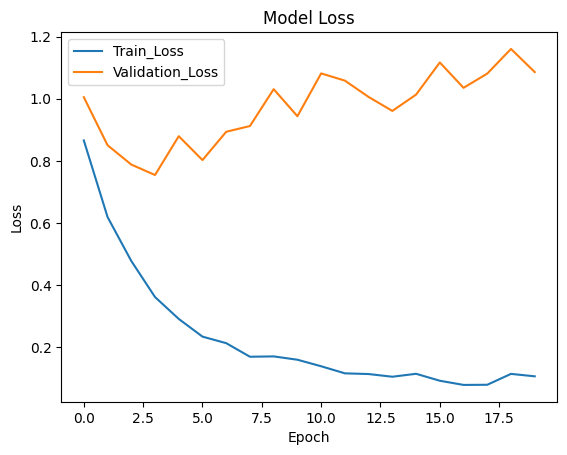

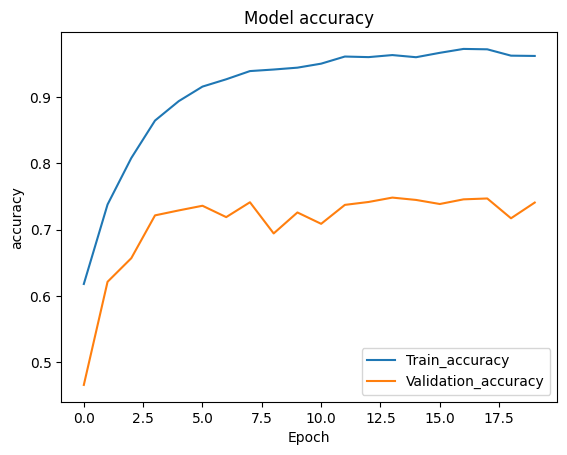

In [292]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Loss', 'Validation_Loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_accuracy', 'Validation_accuracy'])
plt.show()

# **Evaluation**

In [293]:
lenet_model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7335 - loss: 1.1332


[1.0857820510864258, 0.7410008907318115]

# **Testing**

In [294]:
import cv2

test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")

im = tf.constant(test_image, dtype=tf.float32)
print(im.shape)

im = tf.expand_dims(im, axis=0)
print(im.shape)

prediction = lenet_model.predict(im)
print(prediction)

prediction = np.argmax(prediction)
print(class_names[prediction])

(90, 90, 3)
(1, 90, 90, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
[[2.4475364e-07 9.9999917e-01 5.3867706e-07]]
happy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


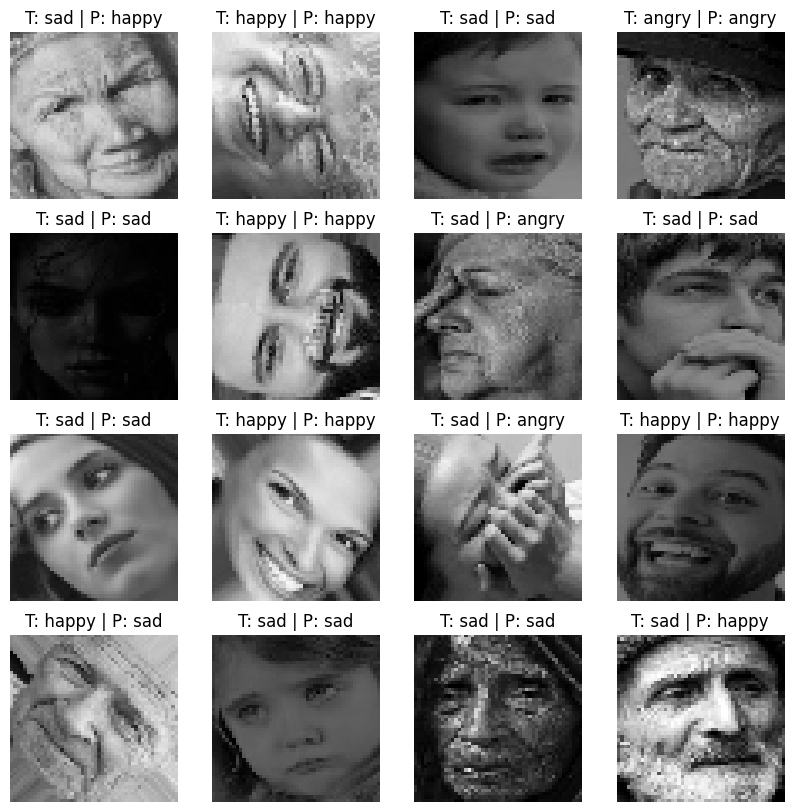

In [295]:
plt.figure(figsize = (10, 10))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    #plt.imshow(images[i]/255) #this also works fine
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("T: " + class_names[labels[i]] + " | P: " + class_names[np.argmax(lenet_model.predict(tf.expand_dims(images[i], axis=0)))])
    plt.axis("off")


plt.show()

confusion matrix

In [296]:
predicted = []
labelss = []

#try
#for im, label in val_dataset.take(1):
for im, label in val_dataset:
  predicted.append(lenet_model.predict(im))
  labelss.append(label.numpy())

print(np.argmax(predicted[:-1], axis=-1).flatten())
print(np.array(labelss[:-1]).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [297]:
pred = np.argmax(predicted[:-1], axis=-1).flatten()
lab = np.array(labelss[:-1]).flatten()

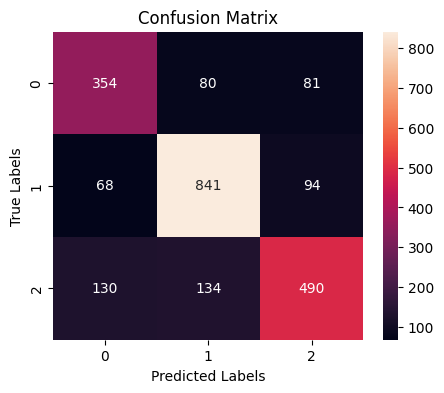

In [298]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(lab, pred)

#Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.title('Confusion Matrix')
plt.show()

# **Data Augmentation to reduce overfitting**